In [273]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [213]:
onfleet = pd.read_csv("export.csv")
database = pd.read_csv("replate.csv")
database = database[["Description", "Scheduled date", "Short", "Id [Location]", 
                     "Number [Location]", "Street [Location]", 
                     "City [Location]", "State [Location]", 
                     "Addr name [Location]"]]
database = database.rename(index = str, columns = {"Description": "pounds", 
                                           "Scheduled date": "date",
                                          "City [Location]": "city", 
                                           "State [Location]": "state",
                                          "Number [Location]": "number", 
                                           "Addr name [Location]": "company",
                                          "Street [Location]": "street"})
#ignore dropoffs 
onfleet = onfleet[onfleet["pickupTask"] == True]
onfleet = onfleet[["shortId"]]
#onfleet = onfleet[["recipients", "shortId", "completeAfter", "completionDetails", "destination"]]
#onfleet = onfleet[~onfleet["completeAfter"].isnull()]
#onfleet["location"] = onfleet["destination"].str.extract("(\[.+?])")
#onfleet["lon"] = pd.to_numeric(onfleet["location"].str.extract("([+-]\d+\.\d+)"))
#onfleet["lat"] = pd.to_numeric(onfleet["location"].str.extract("(, \d+\.\d+)").str.extract("(\d+\.\d+)"))

#def first_10_digits(num):
#    return ((num//10)//10)//10

#onfleet["completeAfter"] = onfleet["completeAfter"].apply(first_10_digits)

#def convert_date(i):
#    return datetime.datetime.fromtimestamp(
#        int(i)
#    ).strftime('%Y-%m-%d')

#onfleet["completeAfter"] = pd.to_datetime(onfleet["completeAfter"].apply(convert_date))
#database = database[["Short", "Addr name [Location]"]]
merged = database.merge(onfleet, left_on = "Short", right_on = "shortId", how = "left")
merged = merged[merged["shortId"].isnull()]

In [363]:
merged = database.merge(onfleet, left_on = "Short", right_on = "shortId", how = "left")
merged = merged[merged["shortId"].isnull()]
locations = pd.read_csv("location.csv")
locations = locations[["Id", "Company name [Business]"]]
ignore = ['Test_Leannon-Kutch', "Billy Bob's Company", 'Test X', 'Testtttttt',
'Pepperdine University ', 'Pepperdine University',
'Test Testing', 'Test company', 'Ryan Hofrichter',
'San Diego Food System Alliance (test sign up)', 
'SDFSA Test', 'Test', 'Lemke, Bernhard and Casper', 'Russel, Little and Cummerata',
'Rippin-Vandervort', 'J.O.N.A.H. INC', "Emily's Company", "Cherry"]

merged = merged.merge(locations, left_on = "Id [Location]", right_on = "Id", how = "left")
merged = merged[~merged["Company name [Business]"].isin(ignore)]
merged["date"] = pd.to_datetime(merged["date"])
merged = merged.drop(["Short", "Id [Location]", "company", "Id"], axis = 1)
merged.loc[merged["pounds"] == ' - ', "pounds"] = "0"
merged.loc[merged["pounds"] == 'Late cancellation', "pounds"] = "0"
merged.loc[merged["pounds"] == 'Requested and immediately canceled over Intercom. Fee not charged. ', "pounds"] = "0"
merged.loc[merged["pounds"] ==  'No data provided or received ', "pounds"] = "0"
merged["month"] = merged["date"].dt.month
merged["day"] = merged["date"].dt.day
merged["year"] = merged["date"].dt.year
days = np.array(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", 
                 "Saturday", "Sunday"])
weekday = []
for i in merged["date"]: 
    weekday.append(i.weekday())
weekday = np.array(weekday)
merged["weekday"] = days[weekday]
splitted = merged["pounds"].str.extractall("(\d*\.?\d*)").unstack()
for col in splitted:
    #convert string to float, otherwise will just be nan
    splitted[col] = pd.to_numeric(splitted[col], errors = "coerce")
#take the maximum float for each of the inputs 
max_pounds = splitted.fillna(0.0).apply(max, axis = 1)
merged["pounds"] = max_pounds

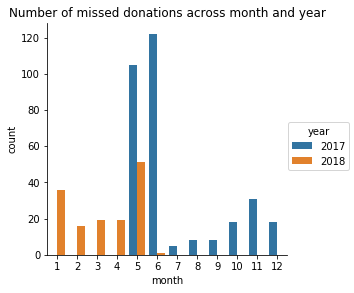

In [364]:
sns.factorplot(x = "month", hue = "year", data = merged, kind = "count");

plt.title("Number of missed donations across month and year");

\begin{align*}
& - \text{There are 457 missing entries in the onfleet data that aren't in the export data}\\
& - \text{Most of the missing entries occurred in May and June 2017.} \\
& \text{Most of the missing entries occurred at the beginning so people probably inputted}\\
& \text{the data into onfleet first and forgot to do so on database} 
\end{align*}

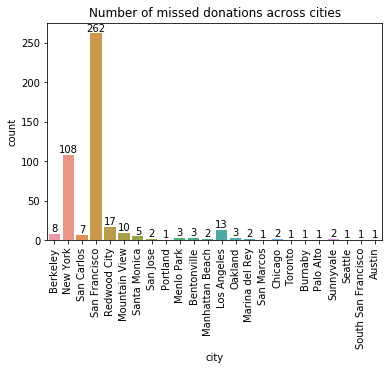

In [365]:
ax = sns.countplot(merged["city"])
for patch in ax.patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
plt.title("Number of missed donations across cities");

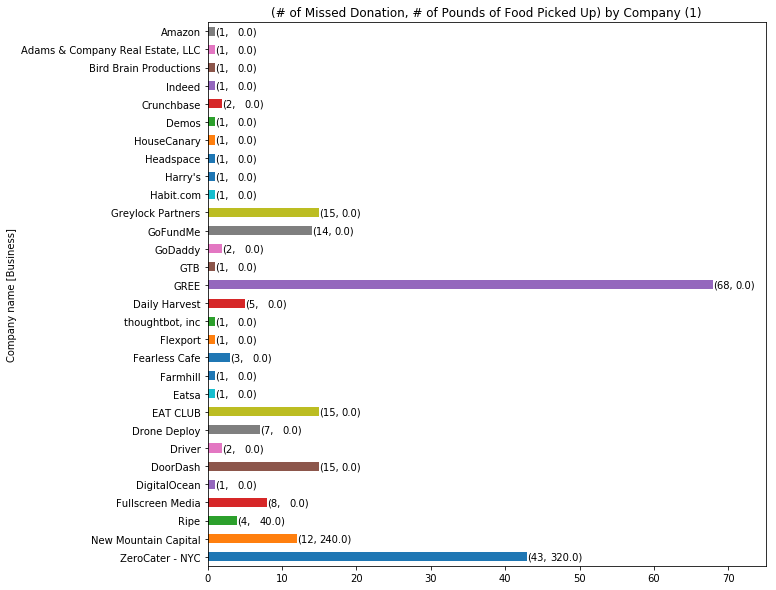

In [366]:
company_counts = merged.groupby("Company name [Business]")["Company name [Business]"].count()
company_pounds = merged.groupby("Company name [Business]")["pounds"].agg(np.sum).sort_values(ascending = False)
company_counts = company_counts.reindex(index = company_pounds.index)
ax1 = company_counts[0:30].plot(kind = "barh", figsize = (10, 10), 
                   title = "(# of Missed Donation, # of Pounds of Food Picked Up) by Company (1)")
for a, b in zip(enumerate(company_counts[0:30]), enumerate(company_pounds[0:30])):
    plt.annotate("(" + str(a[1]) + ",", xy = (a[1], a[0]), va = "center")
    plt.annotate(str(round(b[1],2)) + ")", xy = (a[1] + 3, a[0]), va = "center")
ax1.set_xlim(0, 75);

\begin{align*}
& - \text{Every entry in the onfleet data that didn't the number of pounds picked up is denoted with 0} \\
& - \text{Ripe, New Mountain Capital, and ZeroCater - NYC are the only companies with recorded pounds picked up}\\
& \text{and even then each of the companies still had missing input for the # of pounds picked up}
\end{align*}

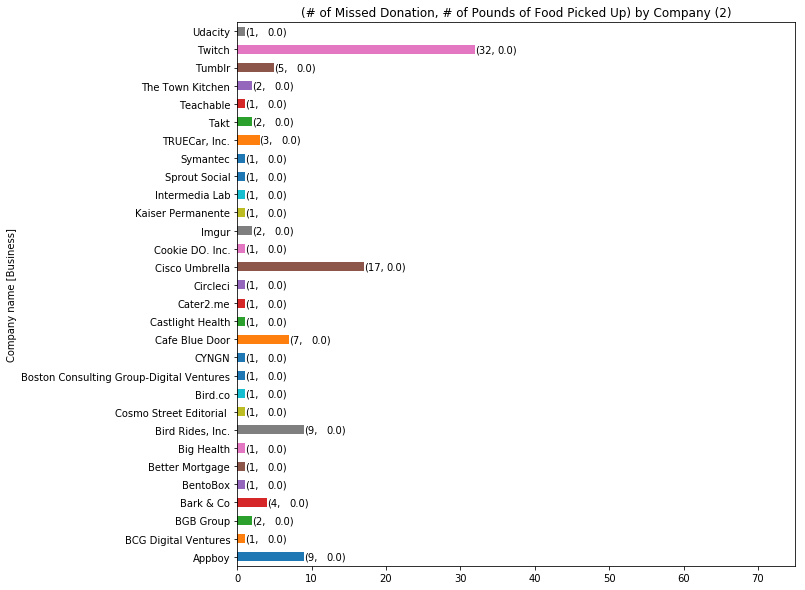

In [357]:
ax1 = company_counts[30:60].plot(kind = "barh", figsize = (10, 10), 
                   title = "(# of Missed Donation, # of Pounds of Food Picked Up) by Company (2)")
for a, b in zip(enumerate(company_counts[30:60]), enumerate(company_pounds[30:60])):
    plt.annotate("(" + str(a[1]) + ",", xy = (a[1], a[0]), va = "center")
    plt.annotate(str(round(b[1],2)) + ")", xy = (a[1] + 3, a[0]), va = "center")
ax1.set_xlim(0, 75);

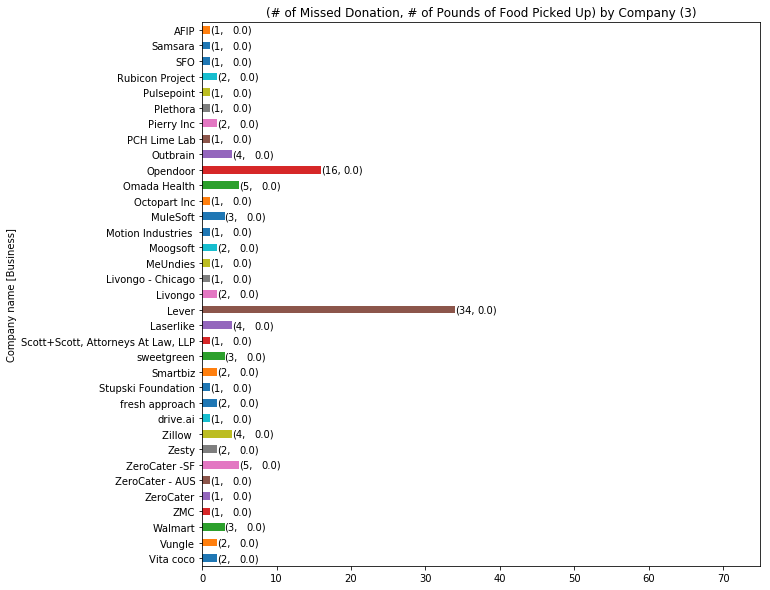

In [358]:
ax1 = company_counts[60:].plot(kind = "barh", figsize = (10, 10), 
                   title = "(# of Missed Donation, # of Pounds of Food Picked Up) by Company (3)")
for a, b in zip(enumerate(company_counts[60:]), enumerate(company_pounds[60:])):
    plt.annotate("(" + str(a[1]) + ",", xy = (a[1], a[0]), va = "center")
    plt.annotate(str(round(b[1],2)) + ")", xy = (a[1] + 3, a[0]), va = "center")
ax1.set_xlim(0, 75);